<a href="https://colab.research.google.com/github/PN-pitchayut/PN-pitchayut/blob/main/Test_Brain_Tumor_Classification_ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np 
import pandas as pd

In [ ]:
# Imports 
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import sklearn
import random
import tensorflow as tf
import os
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# base_path and labels.
base_path = '/content/drive/MyDrive/MRI Brain Tumors'
labels = ['no_tumor', 'pituitary_tumor', 'meningioma_tumor', 'glioma_tumor']

In [ ]:
# Constants
IMAGE_SIZE = 150
BATCH_SIZE = 32
VERBOSE = 1

In [ ]:
# Dataset from the training folder.
x_train=[]
y_train=[]
for i in labels:
    folderPath = os.path.join(os.path.join(base_path,'/content/drive/MyDrive/MRI Brain Tumors/Training'),i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
        x_train.append(img)
        y_train.append(i)
print('Training dataset Loading complete.')

# Dataset from the testing folder..

for i in labels:
    folderPath = os.path.join(os.path.join(base_path,'/content/drive/MyDrive/MRI Brain Tumors/Testing'),i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
        x_train.append(img)
        y_train.append(i)
x_train = np.array(x_train)
y_train = np.array(y_train)
x_train, y_train = sklearn.utils.shuffle(x_train, y_train, random_state=0)

print('Testing dataset Loading complete.')

100%|██████████| 826/826 [00:17<00:00, 46.14it/s] 


Training dataset Loading complete.


100%|██████████| 100/100 [00:01<00:00, 58.40it/s]


Testing dataset Loading complete.


Encoding the y_train and y_test to numbers and one-hot encoding it.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


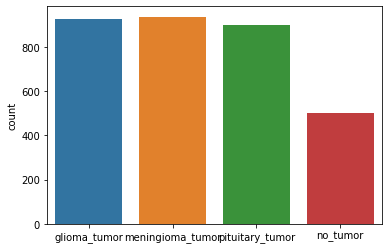

In [ ]:
sns.countplot(y_train)
plt.show()

Sample images in each class

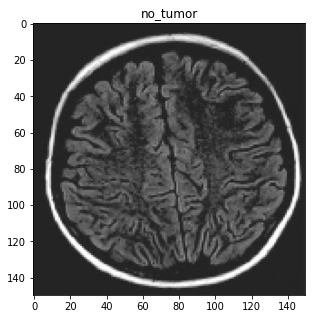

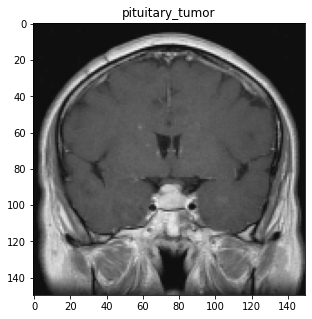

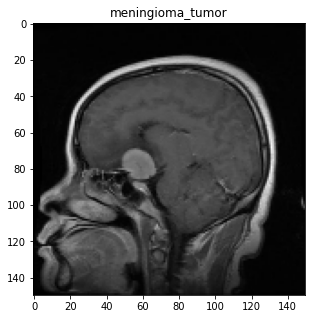

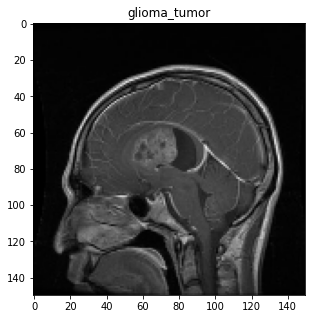

In [ ]:
j=0
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            plt.figure(figsize = (5,5))
            plt.imshow(x_train[j])
            plt.title(y_train[j])
            break
        j+=1

In [ ]:
#Data Augmentation
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True, vertical_flip=False
)

datagen.fit(x_train)
x_train.shape

(3264, 150, 150, 3)

In [ ]:
# Splitting of dataset for Testing.
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size = 0.10, random_state=0)

print("Shapes X : Train :",x_train.shape,  " Test :",x_test.shape)
print("Shapes Y : Train :",y_train.shape,  " Test :",y_test.shape)

Shapes X : Train : (2937, 150, 150, 3)  Test : (327, 150, 150, 3)
Shapes Y : Train : (2937,)  Test : (327,)


Encoding the y_train and y_test to numbers and one-hot encoding it.

In [ ]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

2.Transfer learning_ResNet50

In [ ]:
# Importing the model and initializing.
from tensorflow.keras.applications.resnet import ResNet50
rsnet = ResNet50(weights = 'imagenet',include_top=False,input_shape=(IMAGE_SIZE,IMAGE_SIZE, 3))

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
# Adding Top Layers.
model4 = rsnet.output
model4 = tf.keras.layers.GlobalAveragePooling2D()(model4)
model4 = tf.keras.layers.Dropout(0.5)(model4)
model4 = tf.keras.layers.Dense(4, activation = 'softmax')(model4)
model4 = tf.keras.models.Model(inputs = rsnet.input, outputs = model4)

2.1 Model Summary.

In [ ]:
# Summary of the model.
model4.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 75, 75, 64)   256         ['conv1_conv[0][0]']         

In [ ]:
# Compiling Model
model4.compile(loss = 'categorical_crossentropy', optimizer ='Adam', metrics=['accuracy'])

In [ ]:
# Callbacks.
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,mode='auto',verbose=VERBOSE)

2.2 Training the model.

In [ ]:
# Fitting the model
history4 = model4.fit(x_train, y_train,  validation_split=0.1,epochs = 12,  verbose =VERBOSE, batch_size=BATCH_SIZE, callbacks=[tensorboard,checkpoint, reduce_lr])

Epoch 1/12
83/83 [==============================] - ETA: 0s - loss: 0.8091 - accuracy: 0.7465 
Epoch 1: val_accuracy improved from -inf to 0.16327, saving model to effnet.h5
83/83 [==============================] - 926s 11s/step - loss: 0.8091 - accuracy: 0.7465 - val_loss: 28.5304 - val_accuracy: 0.1633 - lr: 0.0010
Epoch 2/12
83/83 [==============================] - ETA: 0s - loss: 0.3164 - accuracy: 0.8891 
Epoch 2: val_accuracy improved from 0.16327 to 0.41837, saving model to effnet.h5
83/83 [==============================] - 931s 11s/step - loss: 0.3164 - accuracy: 0.8891 - val_loss: 3.7459 - val_accuracy: 0.4184 - lr: 0.0010
Epoch 3/12
83/83 [==============================] - ETA: 0s - loss: 0.2062 - accuracy: 0.9240 
Epoch 3: val_accuracy improved from 0.41837 to 0.61565, saving model to effnet.h5
83/83 [==============================] - 930s 11s/step - loss: 0.2062 - accuracy: 0.9240 - val_loss: 1.9528 - val_accuracy: 0.6156 - lr: 0.0010
Epoch 4/12
83/83 [=====================

2.3 Training, Loss vs epoch.

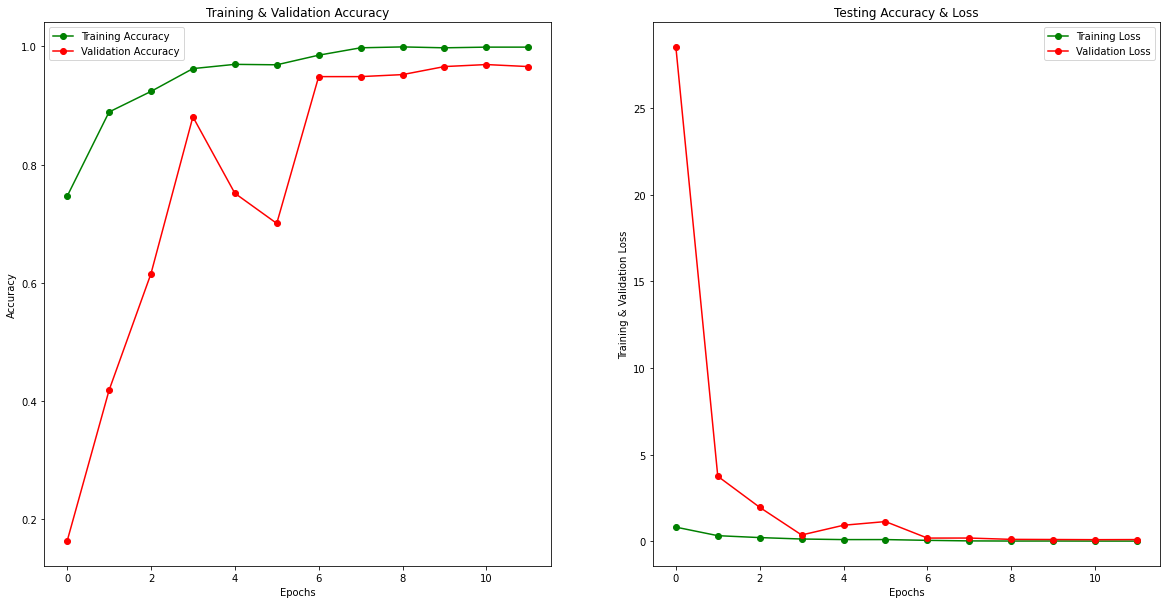

In [ ]:
epochs = [i for i in range(12)]
fig, ax = plt.subplots(1,2)
train_acc = history4.history['accuracy']
train_loss = history4.history['loss']
val_acc = history4.history['val_accuracy']
val_loss = history4.history['val_loss']
fig.set_size_inches(20, 10)

ax[0].plot(epochs, train_acc, 'go-', label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')


ax[1].plot(epochs, train_loss, 'g-o', label ='Training Loss')
ax[1].plot(epochs, val_loss, 'r-o', label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')
plt.show()

2.4 Model Performance

In [ ]:
# Evaluating Model.
result4=model4.evaluate(x_test, y_test)
print("Testing Loss :", result4[0])
print("Testing Accuracy :", result4[1]*100, "%")

11/11 [==============================] - 23s 2s/step - loss: 0.2087 - accuracy: 0.9480
Testing Loss : 0.20871487259864807
Testing Accuracy : 94.80122327804565 %


In [ ]:
predictions4 = model4.predict(x_test)
predictions4 = np.argmax(predictions4, axis = 1)
y_test_edit = np.argmax(y_test , axis = 1)

2.5 Evaluation Metrics

In [ ]:
# Classification report.
cf_report = sklearn.metrics.classification_report(y_test_edit, predictions4 )
print(cf_report)

              precision    recall  f1-score   support

           0       1.00      0.93      0.96        54
           1       0.95      0.98      0.97       103
           2       0.89      0.94      0.91        82
           3       0.98      0.93      0.95        88

    accuracy                           0.95       327
   macro avg       0.95      0.94      0.95       327
weighted avg       0.95      0.95      0.95       327



2.6 Confusion Matrix

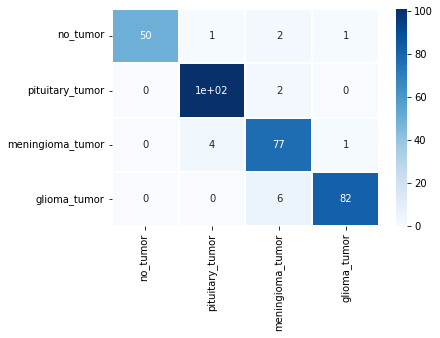

In [ ]:
cf_matrix = sklearn.metrics.confusion_matrix(y_test_edit, predictions4)
sns.heatmap(cf_matrix, cmap = 'Blues', linewidth = 1, annot = True, xticklabels=labels, yticklabels=labels)